In [1]:
#| default_exp lightcurve
%load_ext autoreload
from nbdev.showdoc import show_doc
!date

Thu Dec 15 11:46:35 PST 2022


A "light curve" is a table with columns

- `t` -- time in MJD 
- `tw` -- the cell width
- `n`  -- number of photons
- `e`  -- exposure, in $\mathrm{10^6 s\ cm^2}$ units
- `fit` -- the fit object, containing info about the flux. This is usually a `PoissonRep` object

It is generated from a set of cells. The primary entry is the class `LightCurve`.



In [2]:
#| export
import sys
import numpy as np
import pylab as plt
import pandas as pd
from wtlike.config import *
from wtlike.sources import PointSource
from wtlike.loglike import (LogLike, GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable, poisson_tolerance)
from wtlike.cell_data import CellData

In [3]:
#| exporti
class CellFitter(object):
    """ Apply likelihood fits to a set of cells

    parameters:
       - cells : a table with index t, columns  tw, n, e, w, S, B
       - rep_name : represention to use

    Generates a DataFrame with columns n, ep, fit

    """

    rep_class =  [GaussianRep, Gaussian2dRep, PoissonRep, PoissonRepTable]
    rep_list =   'gauss gauss2d poisson poissontable'.split()

    def __init__(self, config,
                cells,
                source_name,
                rep_name: 'likelihood rep name'='',

                ):
        """Apply fits to the likelihoods for a set of cells

        """
        self.source_name = source_name
        self.config=config
        self.cells = cells

        # generate a list of LogLike objects for each
        cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)

        # analyze using selected rep
        rep_name = rep_name or config.likelihood_rep
        if rep_name not in self.rep_list:
            raise Exception(f'Unrecognized rep: "{rep_name}", must be one of {self.rep_list}')
        repcl = self.rep_class[self.rep_list.index(rep_name)]

        if config.verbose>1:
            print(f'Fitting likelihoods with {rep_name} representation')

        # making output with reduced columns
        self.ll_fits = cells['t tw n e S'.split()].copy() # ignore ctm?

        # add summary of weights, which can be used for fast evaluation if log approx is ok.
        self.ll_fits.loc[:,'wsum'] =  cells.w.apply(lambda w: np.sum(w))
        self.ll_fits.loc[:,'w2sum'] = cells.w.apply(lambda w: np.sum(w**2))
        self.ll_fits.loc[:,'wmax'] =  cells.w.apply(lambda w: np.max(w))

        try:
            self.ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)
        except Exception as e:
            print(f'Failed a fit: \n{e}', file=sys.stderr)
            raise

    def __repr__(self):
        return f'{self.__class__.__name__}: source "{self.source_name}" fit with {len(self.ll_fits)} cells'

    def full_likelihood():
        return LogLike(concatenate_cells(self.cells))

    @property
    def dataframe(self):
        return self.ll_fits

In [4]:
#| exporti
def fit_cells(config,
            input_cells,
            repcl = PoissonRep,

            ):
    """Apply fits to the likelihoods for a set of cells
    return light-curve dataframe

    """
    global poisson_tolerance

    # select the set of cells
    cells = input_cells.copy()

    poisson_tolerance = config.poisson_tolerance
    # generate a list of LogLike objects for each
    cells.loc[:,'loglike'] = cells.apply(LogLike, axis=1)
    if config.verbose>0:
        print(f'LightCurve: Loaded {len(cells)} / {len(input_cells)} cells for fitting')

    # making output with reduced columns
    ll_fits = cells['t tw n e'.split()].copy()
    ll_fits.loc[:,'fit'] = cells.loglike.apply(repcl)

    return ll_fits

In [5]:
#| exporti  

def getCellFitter(config,  source, cell_query='e>1e-6',  key=''):
    """Returns a lightcurve table for the source

    - `source` -- a PointSource object
    - `cell query` -- query to apply to cell selection
    - `bin_edges` -- optional to select other than default described in config
    - `key` -- optional cache key. Set to None to disable cache use

    """
    def doit():
        cell_data = CellData(config,  source)
        cells = cell_data.df.query(cell_query)
        assert len(cells)>0, 'No cells from CellData after query'
        lc = CellFitter(config, cells, source).dataframe
        return lc

#     if bin_edges is None:
        # use cache only with default bins
    key = f'lightcurve_{source_name}' if key=='' else  key
    description = f'Light curve with {cell_query} for {source_name}' if config.verbose>0 and key is not None else ''
    return config.cache(key, doit, description=description)
#     else:
#         return doit()

In [6]:
#| exporti
# def fit_table(lc, expect=1.0):
#     """Generate a summary table from a light curve dataframe"""
#     fits = lc.fit
#     flux = fits.apply(lambda f: f.flux)
#     errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), rorebinnedund(f.errors[1]-f.flux ,3) ) )
#     sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )
#     df = lc['t tw n e'.split()].copy() # maybe fix warnings?
#     df.loc[:,'flux'] = flux.values.round(4)
#     df.loc[:, 'errors'] = errors.values
#     df.loc[:, 'sigma_dev'] = sigma_dev.values
#     df.loc[:, 'limit'] =  fits.apply(lambda f: f.limit)
#     return df

In [7]:
#| export
def utc_check(kwargs):
    utc_flag = kwargs.pop('UTC', False)
    if utc_flag:
        # even years if True else interpret as int
        cnt = 2 if type(utc_flag)==bool else utc_flag
        yrs = [str(yr) for yr in range(2008,2023, cnt)] #get this from kwarg maybe
        yrkw = dict( xticks=[MJD(yr) for yr in yrs], xticklabels=yrs,  xlabel='UTC',)
        kwargs.update(**yrkw)
    return kwargs

def flux_plot(cell_fits,
              query='',
              ax=None, fignum=1, figsize=(12,4),
              log=False,
              title=None,
              step=False,
              tzero=0,
              flux_factor=1,
              colors=('cornflowerblue','sandybrown', 'blue'),
              fmt='', ms=None, error_pixsize=10,
              limit_fmt=None,
              source_name=None,
              legend_loc='upper left',
              error_lw=2,
              ts_bar_min=4,
              zorder=0,
              errorbar_args={},
              axhline={},
              **kwargs):
    """Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

    - cell_fits -- cell fits DataFrame
    - query ['']-- DataFrame query to select subset
    - ts_bar_min -- threshold for plotting as bar vs limit
    - tzero -- time offset, in MJD
    - source_name -- draw text in top left
    - flux_factor [1]

    - ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
    if None, create one using subplots with fignum [1] and figsize [(12,4)]
    - fmt [''] -- marker symbol -- if not specified, will use '.' if many bins, else 'o'
    - ms [None] -- for marker size
    - colors -- tuple of colors for signal, limit, step
    - step   -- add a "step" plot
    - zorder -- set to different number to order successive calls with same Axis object
    - kwargs -- apply to the `ax` object, like xlim, ylim

    returns the Figure instance
    """
    def error_size(ax, x,y, ):
        topix = ax.transData.transform
        frompix = ax.transData.inverted().transform
        sizes = []
        for a,b in zip(x,y):
            sx, sy = topix((a,b))
            c,d = frompix((sx, sy-error_pixsize))
            sizes.append(b-d)
        return  np.array(sizes)

    import matplotlib.ticker as ticker
    kwargs = utc_check(kwargs)
    label = kwargs.pop('label', None)
    step_label = kwargs.pop('step_label', None)

    #error_size=kwargs.pop('error_size', 2)
    # errorbar_args.update(error_size=kwargs.pop('error_size', 2))
    fig, ax = plt.subplots(figsize=figsize, num=fignum) if ax is None else (ax.figure, ax)

    # key words for the Axes object
    kw=dict(xlabel='MJD'+ f' - {tzero} [{UTC(tzero)[:10]}]' if tzero else 'MJD' ,
            ylabel='Relative flux',
            yscale='log' if log else 'linear',
           )
    kw.update(**kwargs)
    ax.set(**kw)
    ax.set_title(title) # or f'{source_name}, rep {self.rep}')

    ax.grid(alpha=0.5)

    # potential yaxis formatting
    if kw['yscale']=='log' and flux_factor==1:
        ax.yaxis.set_major_formatter(ticker.FuncFormatter(
            lambda val,pos: { 1.0:'1', 10.0:'10', 100.:'100'}.get(val,'')))

    # select data to plot
    df = cell_fits.copy()
    df.loc[:,'ts'] = df.fit.apply(lambda f: f.ts)
    if query:
        df = df.query(query)
    # remove any with TS==0, which are null fits
    df = df[df.ts>0]
    if fmt=='':
        fmt='.' if len(df)>200 else 'o'

    limit = (df.ts<ts_bar_min) 
    bar = df.loc[~limit,:]
    lim = df.loc[limit,:]
    allflux= np.select([~limit, limit],
                    [df.fit.apply(lambda f: f.flux).values,
                     df.fit.apply(lambda f: f.limit).values],
                   ) * flux_factor

    # do the limits first (only for poisson rep)
    if len(lim)>0:
        t = lim.t-tzero
        tw = lim.tw
        color = colors[2 if step else 1]

        y = allflux[limit]
        if limit_fmt is None:

            # try to draw an error bar, hard to determine size
            yerr = error_size(ax, t, y) #0.2*(1 if kw['yscale']=='linear' else y)#*flux_factor

            ax.errorbar(x=t, y=y, xerr=tw/2,
                    yerr=yerr,  color=color ,
                    uplims=True, ls='',
                    ms=ms, lw=error_lw, capsize=2*error_lw, capthick=0,
                    zorder=zorder, label='  95% limit', **errorbar_args)
        else:
            # just a symbol, like 'v'
            ax.errorbar(x=t,xerr=tw/2, y=y, fmt=limit_fmt, color=color,
                       zorder=zorder, label='  95% limit', **errorbar_args)

    # then the points with error bars
    t = bar.t.values-tzero
    tw = bar.tw.values.astype(float)
    fluxmeas = allflux[~limit]
    upper = bar.fit.apply(lambda f: f.errors[1]).values * flux_factor
    lower = bar.fit.apply(lambda f: f.errors[0]).values * flux_factor
    error = np.array([upper-fluxmeas, fluxmeas-lower])
#     if label is None:
#         label = f'{bin_size_name(round(tw.mean(),4))} bins' if np.std(tw)<1e-6 else ''
    ax.errorbar(
        x=t, xerr=tw/2, ms=ms,
                y=fluxmeas, yerr=error, lw=2, fmt=fmt,
                color=colors[0],
                label=label, zorder=zorder+1,
                **errorbar_args)

    # finally overlay the step if requested
    if step:
        t = df.t.values-tzero
        xerr = df.tw.values/2;
        x = np.append(t-xerr, [t[-1]+xerr[-1]]);
        y = np.append(allflux, [allflux[-1]])
        ax.step(x, y,
                color=colors[2], where='post', lw=2, label=step_label,  zorder=zorder+2)

    # the legend: if added overplot, make sure it is below
    if legend_loc != 'none':
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles[::-1], labels[::-1],loc=legend_loc, fontsize=10, frameon=False)
        #ax.legend()

    if source_name is not None:
        ax.text(0.99, 0.95, source_name, va='top',  ha='right',  transform=ax.transAxes,)

    return fig

In [8]:
#| include: false
# for testing this
#flux_plot(lc.fits, figsize=(10,5), log=True,  tzero=54720, fmt='D', 
#          xlim=(0,50), ms=8, ylim=(0.05,2), error_pixsize=20);
# source = PointSource('3C 279')
# lc = LightCurve(Config(), source)
# plt.rc('font', size=14)
# ax =flux_plot(lc.fits, figsize=(15,5) ).axes[0];
# yrs = [str(yr) for yr in range(2008,2022,1)]
# mjd_yrs = [MJD(yr) for yr in yrs]
# ax.set(xticks=mjd_yrs, xticklabels=yrs);

# yrs = [MJD(str(yr)) for yr in range(2008,2022)]
# ax.set(xticks=yrs)

In [9]:
show_doc(flux_plot, title_level=2)

---

## flux_plot

>      flux_plot (cell_fits, query='', ax=None, fignum=1, figsize=(12, 4),
>                 log=False, title=None, step=False, tzero=0, flux_factor=1,
>                 colors=('cornflowerblue', 'sandybrown', 'blue'), fmt='',
>                 ms=None, error_pixsize=10, limit_fmt=None, source_name=None,
>                 legend_loc='upper left', error_lw=2, ts_bar_min=4, zorder=0,
>                 errorbar_args={}, axhline={}, **kwargs)

Make a plot of flux vs. time. This is invoked by the `plot` function of `LightCurve`

- cell_fits -- cell fits DataFrame
- query ['']-- DataFrame query to select subset
- ts_bar_min -- threshold for plotting as bar vs limit
- tzero -- time offset, in MJD
- source_name -- draw text in top left
- flux_factor [1]

- ax [None] -- a matplotlib.axes._subplots.AxesSubplot object returned from plt.subplots<br>
if None, create one using subplots with fignum [1] and figsize [(12,4)]
- fmt [''] -- marker symbol -- if not specified, will use '.' if many bins, else 'o'
- ms [None] -- for marker size
- colors -- tuple of colors for signal, limit, step
- step   -- add a "step" plot
- zorder -- set to different number to order successive calls with same Axis object
- kwargs -- apply to the `ax` object, like xlim, ylim

returns the Figure instance

Example plot-- the first 100 days of Fermi data for Geminga

And forcing upper limits

In [10]:
#| exporti
def fit_beta_free(self):
    r"""Make a plot of $\alpha$ and $\beta$ for the given source

    Uses the current cells, assuming Gaussian errors, fitting each to $\alpha$ and $\beta$

    """

    cells = self.cells

    g2rep = cells.apply( lambda cell: Gaussian2dRep(LogLike(cell)).fit, axis=1)

    abdf = pd.DataFrame.from_dict(dict(zip(cells.index,g2rep)), orient='index')
    return abdf

def plot_beta_free(self, abdf):
    cells = self.cells

    fig, (ax1,ax2) = plt.subplots(2,1, figsize=(12,5), sharex=True)
    plt.subplots_adjust(hspace=0, top=0.92)

    t = cells.t; xerr=cells.tw/2
    ax1.errorbar(x=t, xerr=xerr, y=abdf.beta, yerr=abdf.sig_beta, fmt='o');
    ax1.grid(alpha=0.5)
    ax1.set(ylabel=r'$\beta$', xlabel='MJD', title=rf'{self.source_name}: fits with $\beta$ free');
    ax2.errorbar(x=t, xerr=xerr, y=abdf.flux-1, yerr=abdf.sig_flux, fmt='o')
    ax2.set(ylabel=r'$\alpha$')
    ax2.grid(alpha=0.5);
    [ax.axhline(0, ls='--',color='grey') for ax in (ax1,ax2)];

In [11]:
#| exporti
def utc_check(kwargs):
    """ Update Axes kwargs for flux_plot with UTC
    """
    utc_flag = kwargs.pop('UTC', False)
    if not utc_flag: 
        return kwargs
    # even years if True else interpret as int
    cnt = 2 if type(utc_flag)==bool else utc_flag
    yrs = [str(yr) for yr in range(2008,2023, cnt)] #get this from kwarg maybe
    yrkw = dict( xticks=[MJD(yr) for yr in yrs], xticklabels=yrs,  xlabel='UTC',)
    kwargs.update(**yrkw)
    return kwargs

In [12]:
#| export
class LightCurve(CellData):
    """Full analysis of a source,
    Inherits from `CellData`

    """
    def __init__(self, *pars, **kwargs):

        exp_min = kwargs.pop('exp_min', None) # corresponds to ~2counts
        self.n_min = kwargs.pop('n_min', 2)
        self.lc_key = kwargs.pop('lc_key', None)
        super().__init__(*pars, **kwargs)
        self.exp_min = exp_min if exp_min is not None else self.config.exp_min
        self.update()

    def __repr__(self):
        r = super().__repr__()
        r += f'\nLightCurve: {len(self.cells)} cells in view={self.time_bins}'
        r += f', {len(self.fits)} fits with exposure > {self.exp_min*self.time_bins[2]}'
        return r

    def update(self):
        # invoked by current, again if a copy
        # get the cells from superclass

        def doit():
            # fit the subset that have enought exposure and counts
            exp_min = self.exp_min*self.time_bins[2]
            query_string = f'e>{exp_min} & n>{self.n_min}'
            fit_cells = self.cells.query(query_string).copy()
            if self.config.verbose>0:
                print(f'LightCurve: select {len(fit_cells)} cells for fitting with {query_string}' )
            assert len(fit_cells)>0, 'No cells from CellData after query'
            # the local workhorse
            return CellFitter(self.config, fit_cells, self.source_name).dataframe

        # use cache only with default bins?
        key = f'lightcurve_{source_name}' if self.lc_key=='' else  self.lc_key
        if key is None:
            self.fits = doit()
        else:
            description = f'Light curve with {cell_query} for {source_name}' if self.config.verbose>0 and key is not None else ''
            self.fits =  self.config.cache(key, doit, description=description)

    def check_plot_kwargs(self, kwargs):
        tzero = kwargs.get('tzero', None)
        xlim = kwargs.get('xlim', None)
        if xlim is not None and tzero is None: # scale from start, stop times if less than start
            a,b = xlim
            if a<self.start: a = self.start+a if a>=0 else self.stop+a
            if b<self.start: b = self.start+b if b>0 else self.stop+b
            kwargs['xlim'] = (a,b)
        log = kwargs.pop('log', None)
        if log is not None and log:
            kwargs['yscale'] = 'log'
        if  kwargs.pop('show_flux', False):
            kwargs['flux_factor'] = self.src_flux * 1e6
            if kwargs.get('ylabel', None) is None:
                kwargs['ylabel'] = r'Photon flux [$\mathrm{10^{-6} cm^{-2} s^{-1}}$]'
        # utc_flag = kwargs.pop('UTC', False)
        # if utc_flag:
        #     # even years if True else interpret as int
        #     cnt = 2 if type(utc_flag)==bool else utc_flag
        #     yrs = [str(yr) for yr in range(2008,2023, cnt)] #get this from kwarg maybe
        #     yrkw = dict( xticks=[MJD(yr) for yr in yrs], xticklabels=yrs,  xlabel='UTC',)
        #     kwargs.update(**yrkw)

    @decorate_with(flux_plot)
    def plot(self, **kwargs):
        """Make a light curve plot
        Invokes flux_plot, after processing kwargs to intercept
        - log -- translate to `xscale='log'`
        - xlim [None] -- convert to (start, stop) interpreted relative to start, stop if < start.
        - show_flux [False]-- convert y scale to photon flux
        - UTC [False] -- convert x scale to UTC years
-
        """
        source_name = kwargs.pop('source_name', self.source_name)

        # special treatment for log and xlim
        self.check_plot_kwargs(kwargs)

        fig = flux_plot(self.fits,
                        source_name=source_name,
                        label=f'{self.step_name} bins',  **kwargs)
        fig.set_facecolor('white')
        return fig

    def plot_with_exposure(self, **kwargs):
        """Stacked flux plot flux with exposure
        """
        fig,(ax1,ax2) = plt.subplots(2,1, figsize=(15,6), sharex=True);
        fig.subplots_adjust(hspace=0)
        ax1.tick_params(labelbottom=False)
        left, bottom, width, height = (0.15, 0.10, 0.75, 0.85)
        fraction = 0.7
        ax1.set_position([left, bottom+(1-fraction)*height, width, fraction*height])
        ax2.set_position([left, bottom, width, (1-fraction)*height])

        tzero = kwargs.get('tzero', 0)
        self.plot(ax=ax1, **kwargs)

        # the step plot
        ax2.step(self.cells.t-tzero, self.cells.e, '-', where='mid')
        ax2.grid(alpha=0.5)
        ax2.set(ylabel='exposure', ylim=(0,None))
        return fig

    def flux_table(self, lc=None, include_e=True, include_ctm=True):

        """Generate a summary table from the light curve

        - lc -- A light curve fits dataframe; use current one if not specified
        - include_e -- include the exposure
        """
        if lc is None: lc=self.fits

        fits = lc.fit
        flux = fits.apply(lambda f: f.flux)
        errors = fits.apply(lambda f: (round(f.errors[0]-f.flux,3), round(f.errors[1]-f.flux ,3) ) )
        # for future
        #sigma_dev = fits.apply(lambda f: round(f.poiss.sigma_dev(expect),1) )

        df = lc['t tw n'.split()].copy() # maybe fix warnings?
        if include_e:
            df.loc[:,'e'] = self.fits.e
        if include_ctm and 'ctm' in self.cells:
            df.loc[:,'ctm'] = self.cells.ctm
        df.loc[:, 'ts'] =  fits.apply(lambda f: f.ts).round(1)
        df.loc[:,'flux'] = flux.values.round(4)
        df.loc[:, 'errors'] = errors.values
        #df.loc[:, 'sigma_dev'] = sigma_dev.values
        df.loc[:, 'limit'] =  fits.apply(lambda f: f.limit)
        return df

    def fit_beta_free(self, show_plot=True):
        r"""Fit the cells to $\alpha$ and $\beta$, assuming Gaussian errors.

        Make plots if show_plot is set.
        return a DF with the fits.

        """
        abdf = fit_beta_free(self)
        if show_plot:
            plot_beta_free(self, abdf)
        return abdf

    def periodogram(self, tsamp=1/24, **kwargs):
        """Return a Kerr periodogram

        - tsamp -- sample size, default 1/24 or 1 hour, giving a Nyquist frequency of 6 cycles/day.
        """
        from wtlike.time_series import TimeSeries
        return TimeSeries(self, config=self.config, tsamp=tsamp, **kwargs)

    @property
    def fluxes(self):
        """A DataFrame table of the flux measurements"""
        return self.flux_table()

    def __init_subclass__(cls):
        # a subclass must have a doc stsring
        if cls.__doc__ is None:
          raise AttributeError("No docstring")

In [13]:
show_doc(LightCurve)

show_doc(LightCurve.periodogram)

---

### LightCurve.periodogram

>      LightCurve.periodogram (tsamp=0.041666666666666664, **kwargs)

Return a Kerr periodogram

- tsamp -- sample size, default 1/24 or 1 hour, giving a Nyquist frequency of 6 cycles/day.

## Demonstrate TimeSeries 

SourceData:  4FGL J1256.1-0547: Restoring from cache with key "P88Y3243_data"
SourceData: Source 3C 279 with:
	 data:       191,313 photons from 2008-08-04 to 2022-05-26
	 exposure: 3,042,347 intervals,  average effective area 2768 cm^2 for 90.8 Ms
	 rates:  source 4.03e-07/s, background 3.58e-07/s, TS 183590.9
CellData.rebin: Bin photon data into 720 1-week bins from 54683.0 to 59723.0
LightCurve: select 707 cells for fitting with e>35 & n>2
from_fit failed with with TS=27.2 : Bayes violation: P(0)= -8.74 too large for 5 sigma limit. , using fitter
from_fit failed with with TS=27.3 : Bayes violation: P(0)= -9.09 too large for 5 sigma limit. , using fitter
from_fit failed with with TS=32.0 : Bayes violation: P(0)= -10.58 too large for 5 sigma limit. , using fitter
from_fit failed with with TS=34.3 : Bayes violation: P(0)= -8.47 too large for 5 sigma limit. , using fitter
from_fit failed with with TS=35.4 : Bayes violation: P(0)= -11.31 too large for 5 sigma limit. , using fitter
from_f

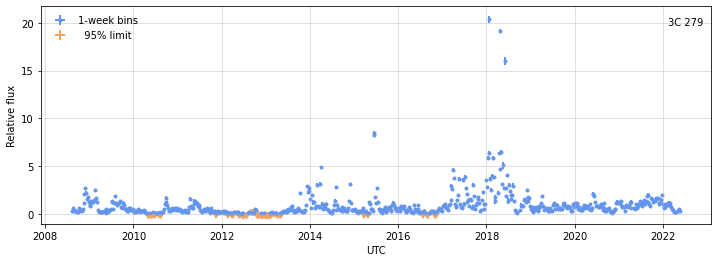

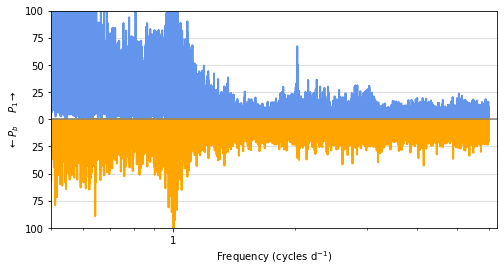

In [14]:
#| code-fold: true
import warnings
warnings.filterwarnings('error', category=RuntimeWarning)
config=Config()
if config.valid:
    lc = LightCurve('3C 279' );
    lc.plot(UTC=True);
    
    from wtlike.time_series import TimeSeries
    ts = lc.periodogram()
    ts.power_plot(pmax=100, xlim=(0.5,None), xscale='log');

In [1]:
#| include: false
import datetime
from utilities.ipynb_docgen import *
display_markdown(f'# Finish build: {str(datetime.datetime.now())[:16]}')
from nbdev import nbdev_export
nbdev_export()
!date

# Finish build: 2022-12-16 05:37

Fri Dec 16 05:37:23 PST 2022
